In [1]:
import os
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import scipy.io as scio
import xarray

import colorcet as cc
from cmcrameri import cm
import matplotlib.pyplot as plt
import proplot as pplt
from scipy import stats
import spotpy
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

#############################################################

dir_in = 'D:/Xanthos-Repo/Data for Figures-Xanthos WM'

In [2]:
basinName = pd.read_csv(dir_in + '/BasinNames235.txt')
basin_id = pd.read_csv(dir_in + '/basin.csv')
GRDC_xanthosCoordIndx = pd.read_csv(dir_in + '/GRDC_stations_list.csv')

basins91 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_91 = [basinName['Basin_Name'][basins91[ii] - 1] for ii in range(GRDC_xanthosCoordIndx.shape[0])]
Xanthos_reservoirs = xarray.open_dataset(dir_in + '/Xanthos_reservoirs_halfDegree_global.nc')
Xanthos_grid_areas = np.array(pd.read_csv(dir_in + '/Grid_Areas_ID.csv'))*1e-2 #Km2
grdc_basin_m3persec  =  pd.read_csv(dir_in + '/grdc_91basin_m3persec_1971_1990_monthly.csv')

### Annual Runoff Depth : Observed

In [3]:
#GRDC
dir_usgrid = dir_in + '/UScells/contributing_grids_all'
grdc_mmmPermonth = np.zeros([91, 240])
grdc_m3persec = np.zeros([91, 240])
SI_grdc = np.zeros([91,])
for ii in range(91):
    
    basin_num = basins91[ii]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad)
    
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    us_area = np.max([GRDC_xanthosCoordIndx['US_Area_SKM'][ii], GRDC_xanthosCoordIndx['US_Area_SKM'][ii]])   

    ####
    #us_area = GRDC_xanthosCoordIndx['US_Area_SKM'][ii]
    grdc_mmmPermonth[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])*(30.4*24*3600)/us_area/1e3 
    grdc_m3persec[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])

# Performance Results filtering

In [4]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    import numpy as np
    from datetime import date, timedelta
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')
    ##
    mean_monthly_data = np.squeeze(np.array(data_ts.groupby(data_ts.index.month).mean()))
    mean_annual_data = np.squeeze(np.array(data_ts.resample('A').sum()))

    return mean_monthly_data, mean_annual_data

In [5]:
def runoff_error(performance_data, QQmm, Qwc, qq):
    QRerror = performance_data['R'] - np.mean(QQmm) - np.mean(Qwc)
    performance_data['QRerror'] = np.abs(QRerror) / np.mean(QQmm)
    q10_wbre = performance_data['QRerror'].quantile(q=qq) 
    index1_q10_wbre = (performance_data['QRerror'] <= q10_wbre) 
    QR_filtered_performance_data = performance_data[index1_q10_wbre].reset_index(drop=True)

    return QR_filtered_performance_data

In [6]:
def peak_time_differnce(WB_filtered_performance_data, lowRII_Basins, basin_num):   
    if len(np.where(lowRII_Basins==basin_num)[0]) > 0:   
        indx_months_pt1 = ((WB_filtered_performance_data['MNTH_PDiff'] >= -1) & (WB_filtered_performance_data['MNTH_PDiff'] <= 3))
        PT_filtered_performance_data = WB_filtered_performance_data[indx_months_pt1].reset_index(drop=True)
        
        if PT_filtered_performance_data.shape[0] < 100:
            indx_months_pt2 = ((WB_filtered_performance_data['MNTH_PDiff'] >= -2) & (WB_filtered_performance_data['MNTH_PDiff'] <= 3))
            PT_filtered_performance_data = WB_filtered_performance_data[indx_months_pt2].reset_index(drop=True)

    else:
        PT_filtered_performance_data = WB_filtered_performance_data
    
    return PT_filtered_performance_data


In [7]:
def runoff_model_output(dir_in, basin_num):
    os.chdir(dir_in)
    basin_calibration =  pd.read_csv('basin_calibration_' + str(basin_num) + 'c.csv')
    basin_calibration = basin_calibration.drop(['para',	'parb',	'parc',	'pard',	'parm'], 1)
    ## basin_abcd
    basin_abcd = basin_calibration[['simulation1_1', 'simulation1_2', 'simulation1_3', 'simulation1_4', 'simulation1_5']]
    basin_abcd.columns = ['par_a',	'par_b',	'par_c',	'par_d',	'par_m']
    basin_calibration = basin_calibration.drop(['simulation1_1', 'simulation1_2', 'simulation1_3', 'simulation1_4', 'simulation1_5'], 1)

    ######### Runoff
    ## basin annual runoff
    no_years = 31
    basin_annaul_header = ['simulation2_' + str(ii+1) for ii in range(no_years)]
    basin_annaul_RO  = basin_calibration[basin_annaul_header]

    basin_annaul_RO.columns = np.arange(1971,2002, 1)   
    ## basin mean monthly runoff
    no_months = 12
    basin_MM_header = ['simulation3_' + str(ii+1) for ii in range(no_months)]
    basin_MM_RO   = basin_calibration[basin_MM_header]
    basin_MM_RO.columns  = [['Ja', 'Fb', 'Mr', 'Ap', 'My', 'Ju', 'Jl', 'Ag', 'Sb', 'Oc', 'Nv', 'Dc']]

    return basin_abcd, basin_annaul_RO, basin_MM_RO


In [8]:
def Rsquared_matrix(basin_annual_runoff_all, annual_ro_mat):
    aa1 = pd.DataFrame(annual_ro_mat) - np.mean(annual_ro_mat)
    mm_meanro = np.reshape(np.tile(np.mean(basin_annual_runoff_all, 1),20), 
                                  [20, basin_annual_runoff_all.shape[0]]).transpose()
    aa2 = pd.DataFrame(basin_annual_runoff_all) - mm_meanro
    aa = np.multiply(aa1,aa2).sum(axis=1)
    bb1 = (aa1**2).sum(axis=1)
    bb2 = (aa2**2).sum(axis=1)
    bb = np.sqrt(np.multiply(bb1, bb2))

    rcoeff = np.array(np.divide(aa, bb))

    return rcoeff

In [9]:
def kge_matrix(basin_annual_runoff_all, annual_ro_mat, annual_ro):    
    stdbais_annual_ro  = (1 - (np.std(basin_annual_runoff_all,1) /np.std(annual_ro)))**2
    meanbais_annual_ro = (1 - (np.mean(basin_annual_runoff_all,1) /np.mean(annual_ro)))**2
    rsquared_bias      = ( 1 - Rsquared_matrix(basin_annual_runoff_all, annual_ro_mat))**2
    ed_distance = stdbais_annual_ro + meanbais_annual_ro + rsquared_bias
    kge_value_ = 1 - np.sqrt(ed_distance)
    return kge_value_

### Filtering based on Annual Runoff

In [10]:
def parameters_set_selection(performance_data_in, grdc_depth, basins94, basin_num): 
    # runoff data
    performance_data = performance_data_in.copy()
    bb = np.where(basins94==basin_num)[0]
    performance_data.columns = [1,2,3,4,5,6,7,8,9,10,11,12]
    performance_data['MNTH_RP'] = np.array(performance_data.idxmax(axis=1))


    #Q: Peak timing   
    QQmm, QQaa = timeseries_coverter(grdc_depth, start_yr=1971, ending_yr=1990)
    QQmm_df = pd.DataFrame(QQmm)
    QQmm_df.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    performance_data['MNTH_QP'] = QQmm_df.idxmax()[0]*np.ones([performance_data.shape[0],])

    # difference
    performance_data['PT_Diff'] = performance_data['MNTH_QP'] - performance_data['MNTH_RP']

    return performance_data

### Plotting 

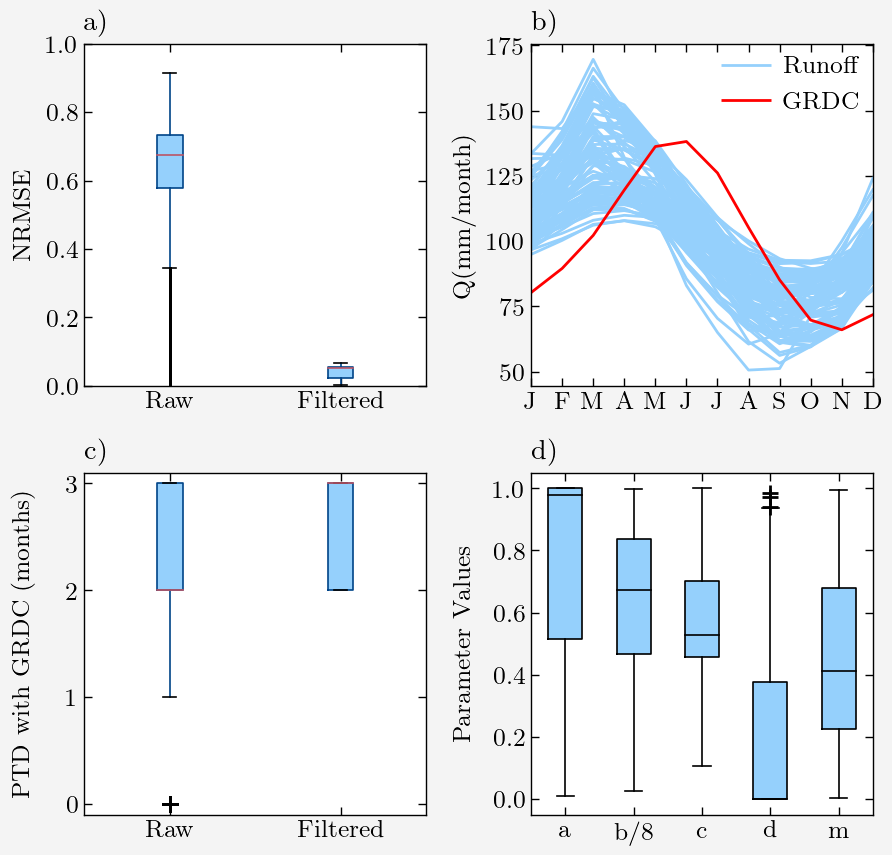

In [11]:
start_yr = 1971
ending_yr = 1990

dir_in_data = dir_in + '/WATCH-1M-Run-abcdm'
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}

#basin ID
basin_num = 168
bb = np.where(basins91==basin_num)[0]

## Get data : simulated   
basin_abcd, basin_annaul_RO, basin_MM_RO = runoff_model_output(dir_in_data, basin_num)
QQmm, QQaa = timeseries_coverter(np.squeeze(grdc_mmmPermonth[bb,:]), start_yr=1971, ending_yr=1990)
basin_annaul_RO['Qannual_error'] = np.abs(basin_annaul_RO.mean(axis=1) - np.mean(QQaa))/np.mean(QQaa)
basin_annual_runoff = np.array(basin_annaul_RO)

## Get data : observed    
mean_monthly_ro, annual_ro = timeseries_coverter(np.squeeze(grdc_mmmPermonth[bb,:]), start_yr, ending_yr)
annual_ro_dup = np.multiply(np.ones_like(basin_annual_runoff[:,0:20]),annual_ro)
rmse_annual_ro = np.sqrt(np.sum((basin_annual_runoff[:,0:20] - annual_ro_dup)**2, 1))  / len(annual_ro) #Runoff rmse

##filter 1
qt1 = 10000/len(rmse_annual_ro)
indxRO_rmse = (rmse_annual_ro <= pd.DataFrame(rmse_annual_ro).quantile(qt1)[0])
filter1_basin_annaul_RO = basin_annaul_RO[indxRO_rmse].reset_index(drop=True)
filter1_ai_annual_ro = rmse_annual_ro[indxRO_rmse]
filter1_params_abcd = basin_abcd[indxRO_rmse].reset_index(drop=True)
filter1_basin_MM_RO = basin_MM_RO[indxRO_rmse].reset_index(drop=True)


### filter 2
indxET_rmse = (filter1_ai_annual_ro <= pd.DataFrame(filter1_ai_annual_ro).quantile(0.01)[0])
filter2_basin_annaul_RO = filter1_basin_annaul_RO[indxET_rmse].reset_index(drop=True)
filter2_params_abcd = filter1_params_abcd[indxET_rmse].reset_index(drop=True)
filter2_basin_MM_RO = filter1_basin_MM_RO[indxET_rmse].reset_index(drop=True)


#############################################################################################    
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
    fig, axs = pplt.subplots(nrows=2, ncols=2,  share=0, journal='pnas2')
    ############ Water Balance Error
    ax = axs[0]
    new_all_errors = pd.concat([basin_annaul_RO[['Qannual_error']], 
                            filter2_basin_annaul_RO[['Qannual_error']]], ignore_index=False, axis=1)     
    new_all_errors.columns = ['Raw','Filtered']
    new_all_errors.boxplot(ax=ax,facecolor='light blue', sym='+', markersize=1)
    ax.format(ylabel='NRMSE', abcstyle='a)',  grid=False,  titleloc='l')
    ax.set_ylim([0,1])
    ax.minorticks_off()


    ############## Mean Monthly
    ax = axs[1]   
    df = filter2_basin_MM_RO.transpose()
    cols = ["_" + str(col) for col in df.columns]
    cols[0] = 'Runoff'
    df.columns = cols
    df.index = np.arange(0,12,1)

    df.plot(ax=ax, color='light blue', label=str())
    ax.plot(QQmm, 'r', label='GRDC')
    ax.format(ylabel='Q(mm/month)', abcstyle='a)',  grid=False,  titleloc='l')
    major_xticks = np.arange(0, 12, 1)
    ax.set_xticks(major_xticks)
    ax.set_xticklabels(['J','F','M','A','M', 'J','J','A','S','O','N','D'])
    ax.legend(ncols=1)
    ax.minorticks_off()



    ############## Peak time difference
    performance_data = parameters_set_selection(basin_MM_RO, np.squeeze(grdc_mmmPermonth[bb,:]), basins91, basin_num)
    performance_data1 = parameters_set_selection(filter1_basin_MM_RO, np.squeeze(grdc_mmmPermonth[bb,:]), basins91, basin_num)
    performance_data2 = parameters_set_selection(filter2_basin_MM_RO, np.squeeze(grdc_mmmPermonth[bb,:]), basins91, basin_num)
    new_all_peaktime = pd.concat([performance_data[['PT_Diff']], 
                                    performance_data2[['PT_Diff']]], ignore_index=False, axis=1)     
    new_all_peaktime.columns = ['Raw','Filtered']
    ax = axs[2]
    new_all_peaktime.boxplot(ax=ax,facecolor='light blue', sym='+')
    ax.set_ylim([-.1, 3.1])
    ax.format(ylabel='PTD with GRDC (months)', abcstyle='a)',  grid=False,  titleloc='l')
    ax.minorticks_off()

    ############## Params
    ax = axs[3]
    params_abcd = pd.DataFrame(np.array(filter2_params_abcd.copy()))
    params_abcd.columns = ['a','b','c','d','m']
    params_abcd['b'] = params_abcd['b']/8

    ax.boxplot(np.array(params_abcd) ,facecolor='light blue', sym='+')
    ax.set_xticklabels(['a','b/8','c','d','m'])     
    ax.format(ylabel='Parameter Values', abcstyle='a)',  grid=False ,  titleloc='l')  
    ax.minorticks_off()


fig.align_ylabels(axs)
plt.tight_layout()   

#dir_out = 'D:\\Xanthos-Repo\\figures\\'
#plt.savefig(dir_out + "Figure-6.png", **SAVE_KWDS)  